In [1]:
# If running on colab, uncomment the line below and run this cell:
#!pip in stall devito

# From Zero to Devito: Geophysical modeling with Devito

- Devito is a domain specific language (DSL) for formulating partial differential solvers in the form of finite difference operators.
- From a users perspective, they formulate the problem in a similar manner to how they would on pen and paper.
- Devito then compiles this formulation into c code optimized for the target platform.
- A main target application of Devito is producing wave-propagation kernels for use in inversion/imaging frameworks (RTM and FWI).

This workshop will be divided into 3 sections:
1. Basics of the DSL
3. Building propagators
4. Constructing FWI frameworks

For convenience, we import all Devito modules:

In [2]:
from devito import *

# Part 1: The Devito DSL - From equations to code in a few lines of Python

## Goals:

- Introduce users to some of the core *Devito* objects including grids (`Grid`), functions (`Function`, `TimeFunction`), equations (`Eq`) and operators (`Operator`)
- Illusrate how the DSL can be used to produce a range of finite difference (FD) stencils
- Execute a simple operator

The main objective of this tutorial is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We demonstrate how computational stencils can be derived directly from the equation in an automated fashion and how Devito can be used to generate and execute, at runtime, the desired numerical scheme in the form of optimized C code.


## Defining the physical domain

Before we can begin creating finite-difference (FD) stencils we will need to give Devito a few details regarding the computational domain within which we wish to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretise our data.

<img src="figures/grid.png" style="width: 320px;"/>

In [3]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

## Functions and data

To express our equation in symbolic form and discretise it using finite differences, Devito provides a set of `Function` types. A `Function` object:

1. Behaves like a `sympy.Function` symbol
2. Manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can take a look at the documentation.

In [4]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating `Function` objects.

In [5]:
f = Function(name='f', grid=grid)
f

f(x, y)

In [6]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default, Devito `Function` objects use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE over several timesteps a time dimension is also required by our symbolic function. For this Devito provides an additional function type, the `TimeFunction`, which incorporates the correct dimension along with some other intricacies needed to create a time stepping scheme.

In [7]:
g = TimeFunction(name='g', grid=grid)
g

g(t, x, y)

Since the default time order of a `TimeFunction` is `1`, the shape of `f` is `(2, 5, 6)`, i.e. Devito has allocated two buffers to represent `g(t, x, y)` and `g(t + dt, x, y)`:

In [8]:
g.shape

(2, 5, 6)

**A note on the size of the time dimension:** By default, the time dimension will be allocated with the minimum number of elements required by the time-stepping scheme employed. The default `time_order` is `1` for which time stepping schemes will be of the form

\begin{equation*}
 \mathbf{g}^{(n+1)}=f(\mathbf{g}^{(n)}),
\end{equation*}

that is, we need to store the field $g$ at the *current* and *next* time step and hence the size of 2. The c code will then be generated with *modulo time-stepping* to account for this (we'll see an example below). Therefore, given a time step $dt$ we would have that

| $g(t)$      | Location stored |
| ----------- | ----------- |
| $g(0)$      | `g.data[0]`      |
| $g(dt)$   | `g.data[1]`        |
| $g(2dt)$      | `g.data[0]` |
| $g(3dt)$   | `g.data[1]` |
| $g(4dt)$   | `g.data[0]` |

and so forth.

To solve a PDE that is second order in time directly, such as we'll do later when solving the second order wave-equation, we'll need to time-stepping scheme with a minimum time order of 2. If we define, e.g.,

`g = TimeFunction(name='g', grid=grid, time_order=2)`

then the time dimension of `g` would now have a size of 3 since the time-stepping scheme would look like

\begin{equation*}
 \mathbf{g}^{(n+1)}=f(\mathbf{g}^{(n)}, \mathbf{g}^{(n-1)}).
\end{equation*}

We would then have `data` stored as follows

| $g(t)$      | Location stored |
| ----------- | ----------- |
| $g(0)$      | `g.data[0]`      |
| $g(dt)$   | `g.data[1]`        |
| $g(2dt)$      | `g.data[2]` |
| $g(3dt)$   | `g.data[0]` |
| $g(4dt)$   | `g.data[1]` |
| $g(5dt)$   | `g.data[2]` |
| $g(6dt)$   | `g.data[0]` |

If we with to save the value of a function at each time-step (and avoid over-writing the function at old time steps as is the default mode of operation) we can make use of the `save` parameter. That is, if we wish to store the function at 1000 different points in time (i.e. set the function to have a time-dimension size of 1000)  we can define

`g = TimeFunction(name='g', grid=grid, save=1000)`

and in this case the c code would then be generated without modulo time-stepping.

Above, we've just scratched the surface of some basic configurations available. In practice, we may wish to subsample a field in time, implement a checkpoint method or so on. For further discussion, please see further tutorials and information located [here](https://github.com/devitocodes/devito/blob/master/examples/userapi/02_apply.ipynb), [here](https://github.com/devitocodes/devito/blob/master/examples/userapi/05_conditional_dimension.ipynb) and [here](https://github.com/devitocodes/pyrevolve).

## Forming finite difference schemes

Let us start by considering the simple example of 2D linear convection. But first, lets review some basics of finite differences.

Recall that the Taylor series of $f(x,t)$ in the spatial dimension takes the form

\begin{equation*}
 f(x+h,t)=f(x,t)+\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2+\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

We can re-arrange the above expansion in the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)}{h}-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.
\end{equation*}

Thus, provided $h$ is small we can say

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x+h,t)-f(x,t)}{h},
\end{equation*}

which will have an associated error

\begin{equation*}
-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n
\end{equation*}

This is the well known *forward difference* approximation (or the *right* derivative) and is how spatial derivatives are approximated in 'space order' 1 finite difference schemes.

We can also write the following Taylor expansion

\begin{equation*}
 f(x-h,t)=f(x,t)-\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2-\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

This leads to the backward difference (or *left* derivative) approximation:

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x,t)-f(x-h,t)}{h}.
\end{equation*}

In Devito, these derivatives can be represented via the following symbolic notation:

In [9]:
f.dxr # Forward difference/right derivative

Derivative(f(x, y), x)

In [10]:
f.dxl # Backward difference/left derivative

Derivative(f(x, y), x)

And to see the actual stencils they represent, we enduce the `evaluate` method:

In [11]:
f.dxr.evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

In [12]:
f.dxl.evaluate

f(x, y)/h_x - f(x - h_x, y)/h_x

which we see correspond with the expressions derived from the Taylor series above. Note that we also have access to the expression  `f.dx` which, in this particular instance, will produce a stencil equivalent to `f.dxr`. (We'll come back to this shortly when considering higher order stencils).

In [13]:
f.dx.evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

The functions we created above all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions from them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretised it with a finite difference expression.

| Derivative | Shorthand | Discretised | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right)) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left)) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

We can form stencils for approximating the derivatives in any other spatial or time dimension in a similar manner.
Let us introduce the function $u(x,y,t)$. We have

\begin{equation*}
 \frac{\partial u}{\partial t}\approx\frac{u(x, y, t+\delta t)-u(x, y, t)}{\delta t},
\end{equation*}

where $\delta t$ is some small increment in time. This then allows us to create 'time-stepping schemes'. For example, consider the partial differential equation describing 2D linear advection

\begin{equation*}
 \frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y}=0,
\end{equation*}

discretizing only the temporal term for the time being we have

\begin{equation*}
 \frac{u(x, y, t+\delta t)-u(x, y, t)}{\delta t}+c\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right)=0,
\end{equation*}

which we can re-arrange as

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right),
\end{equation*}

which is one of the most basic *explicit* time stepping schemes. Now if we approximated our spatial derivative with a backward difference approximation our scheme will become

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{u(x, y, t)-u(x-h, y, t)}{h} +\frac{u(x, y, t)-u(x, y-h, t)}{h}\right).
\end{equation*}

(Note that here we have assumed an equal grid spacing $h_x=h_y=h$). Then, provided we know the status of our function $u$ at $t=0$ we can use the above scheme to compute the evolution of $u$ forward in time. Lets now implement this scheme in Devito.

We first define our grid, the function $u$ and provide an initial condition:

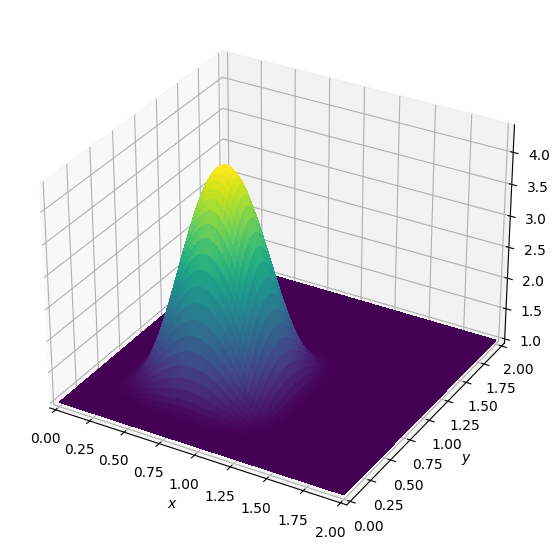

In [14]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_smooth(field=u.data[0], dx=grid.spacing[0], dy=grid.spacing[1])
init_smooth(field=u.data[1], dx=grid.spacing[0], dy=grid.spacing[1])

plot_field(u.data[0])

Next we formulate our equation and finite difference scheme:

In [15]:
eq = Eq(u.dt + c * u.dxl + c * u.dyl, 0)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

In [16]:
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt))

We can check our `update` scheme is the same as our pen and paper scheme by `evaluate`ing it:

In [17]:
update.evaluate

Eq(u(t + dt, x, y), dt*(-(u(t, x, y)/h_x - u(t, x - h_x, y)/h_x) - (u(t, x, y)/h_y - u(t, x, y - h_y)/h_y) + u(t, x, y)/dt))

Finally we need to create and execute a Devito operator. This is where the *magic* happens: Devito takes our symbolic specification of the boundary value problem and through a number of compilation passes produces c code optimised for the target platform. We'll talk more about `Operator` objects in the following section, for now we'll just utilize it

Operator `Kernel` ran in 0.01 s


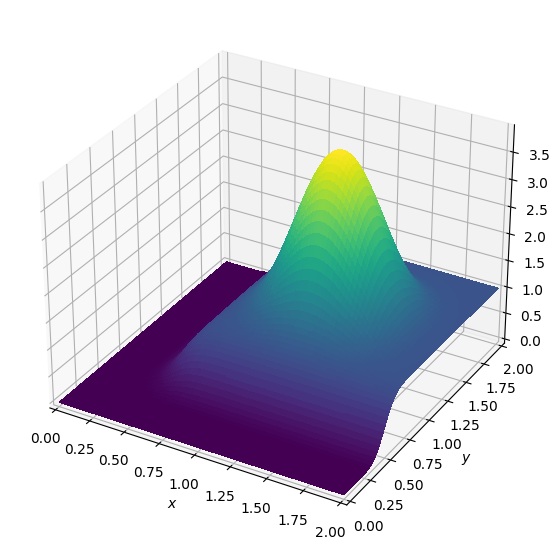

In [18]:
op = Operator(update)
op(time=nt+1, dt=dt)

plot_field(u.data[0])

We can view the generated c code via

In [19]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  /* Flush denormal numbers to zero in hardware */
  

There also exist a range of other convenient shortcuts. For example, the forward and backward stencil points, `g(t+dt, x, y)` and `g(t-dt, x, y)`.

In [20]:
g.forward

g(t + dt, x, y)

In [21]:
g.backward

g(t - dt, x, y)

And of course, there's nothing to stop us taking derivatives on these objects:

In [22]:
g.forward.dt

Derivative(g(t + dt, x, y), t)

In [23]:
g.forward.dy

Derivative(g(t + dt, x, y), y)

## Second derivatives and high-order stencils

The logic for constructing derivatives and finite difference schemes introduced above carries over higher order derivatives and higher order approximations in a straightforward manner. For example, second derivative with respect to $x$ of order two,

\begin{equation*}
  \frac{\partial^2 f}{\partial x^2}=\frac{f(x-h,t)-2f(x,t)+f(x+h,t)+\mathcal{O}(h^3)}{h^2},
\end{equation*}

can be implemented via `f.dx2`. Note however, if we attempt to compute this using the `f` defined above we will see an error:

In [24]:
# f.dx2 # Uncomment to see the error

Note the `AttributeError: f object has no attribute 'dx2'`. Let us review the function documentation again:

In [25]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Note the optional argument `space_order`. We didn't previously pass this argument and hence it took the default value of 1. That is, defining it in this way, it can only support spatial derivatives of order **one** (or schemes of oder one). If we wish to construct higher order derivatives or schemes, we can do so as follows:

Pass the desired `space_order` when constructing a function. For example

In [26]:
f = Function(name='f', grid=grid, space_order=2)

In [27]:
f.dx2.evaluate

-2.0*f(x, y)/h_x**2 + f(x - h_x, y)/h_x**2 + f(x + h_x, y)/h_x**2

And if, for example, we wish to produce fourth order accurate first derivatives

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{\frac{1}{12}f(x-2h,t)-\frac{2}{3}f(x-h,t)+\frac{2}{3}f(x+h,t)-\frac{1}{12}f(x+2h,t)+\mathcal{O}(h^5)}{h},
\end{equation*}

we can do so in the following manner:

In [28]:
f = Function(name='f', grid=grid, space_order=4)
f.dx.evaluate

0.0833333333*f(x - 2*h_x, y)/h_x - 0.666666667*f(x - h_x, y)/h_x + 0.666666667*f(x + h_x, y)/h_x - 0.0833333333*f(x + 2*h_x, y)/h_x

By default, Devito will produce schemes with the order `space_order` used when defining a `Function`.

We can override this by explicitly passing the space order of the desired scheme when creating a symbolic expression for a derivative. For example:

In [29]:
f.dx(fd_order=2).evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

Note that `fd_order` cannot exceed the `space_order` with which a `Function` was defined.

Time derivatives follow a similar principle, we simply instead pass the desired `time_order` to a function, e.g.,

In [30]:
g = TimeFunction(name='g', grid=grid, time_order=2, space_order=4)

In [31]:
g.dt2.evaluate+g.dy.evaluate

-2.0*g(t, x, y)/dt**2 + g(t - dt, x, y)/dt**2 + g(t + dt, x, y)/dt**2 + 0.0833333333*g(t, x, y - 2*h_y)/h_y - 0.666666667*g(t, x, y - h_y)/h_y + 0.666666667*g(t, x, y + h_y)/h_y - 0.0833333333*g(t, x, y + 2*h_y)/h_y

To implement the diffusion or wave equations, we must take the Laplacian $\nabla^2 u$, which is the sum of the second derivatives in all spatial dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`'s:

In [32]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

u(t, x, y, z)

We can re-define our function `u` with a different `space_order` argument to change the discretisation order of the stencil expression created. For example, we can derive an expression of the 12th-order Laplacian $\nabla^2 u$:

In [33]:
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

The same expression could also have been generated explicitly via:

In [34]:
u.dx2 + u.dy2 + u.dz2

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

## Derivatives of composite expressions

Derivatives of any arbitrary expression can easily be generated:

In [35]:
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [36]:
v.dt2 + u.laplace

Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2))

In [37]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

Which can, depending on the chosen discretisation, lead to fairly complex stencils: 

In [38]:
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2)/h_x**2